# Uebung 2

# 2) Eigengesichter

In [118]:
import pandas as pd
import numpy as np
import matplotlib as mp
import tarfile
import os.path
import urllib.request
import skimage
import scipy as sp

## 2a) Bilder herunterladen und die meisten aussuchen

In [119]:
filename = "lfw-funneled.tgz"
url = "http://vis-www.cs.umass.edu/lfw/" + filename
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)
    dateDownloaded = !date
    print(dateDownloaded)

In [120]:
tar = tarfile.open(filename)
tar.extractall()
tar.close()
foldername = "lfw_funneled"

In [121]:
persons = {}
for personName in os.listdir(foldername):
    current_person = foldername + "/" + personName
    if os.path.isdir(current_person):
        if len(os.listdir(current_person)) >= 70:
               persons.update({personName: [current_person +"/"+item for item in os.listdir(current_person)] })
persons.keys()

dict_keys(['Hugo_Chavez', 'George_W_Bush', 'Tony_Blair', 'Colin_Powell', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Ariel_Sharon'])

## 2b) Bilder einlesen und verkleinern

In [122]:
from skimage import io
from skimage import transform

resized_images = []
resized_names = []
resized_last_images = []
resized_last_names = []

for person_name, person in zip(persons.keys(), persons.values()):
    path = person.copy()
    #del path[-1]
    for picture_path in path:
        picture = io.imread(picture_path,  as_grey=True)
        picture = picture[55:195, 75:175]
        resized_image = transform.resize(picture, (32, 32)).flatten()
        if not picture_path == path[-1]:
            resized_images.append(resized_image)
            resized_names.append(person_name)
        else:
            resized_last_images.append(resized_image)
            resized_last_names.append(person_name)

resized_images = np.array(resized_images)
resized_names = np.array(resized_names)
resized_last_images = np.array(resized_last_images)
resized_last_names = np.array(resized_last_names)
        
resized_images.shape, resized_names.shape, resized_last_images.shape, resized_last_names.shape

((1281, 1024), (1281,), (7, 1024), (7,))

## 2c)  Hauptkomponentenanalyse anwenden

In [123]:
training_data_mean = resized_images.mean(axis=0)
centralized_training_data = resized_images.copy()
centralized_training_data=centralized_training_data-training_data_mean

U, D, Vt = np.linalg.svd(resized_images)
U.shape, D.shape, Vt.shape

((1281, 1281), (1024,), (1024, 1024))

Die ersten 150 Eigenwerte im Diagramm darstellen

Populating the interactive namespace from numpy and matplotlib


/home/dyon/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


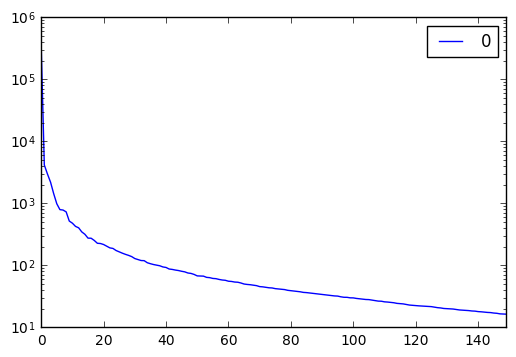

In [124]:
eigenvalues = np.square(D)
eigen_values_dataframe = pd.DataFrame(eigenvalues[0:150])

%pylab inline
eigen_values_dataframe.plot(logy=True)

Interpretation der Ergebnisse:

Die Lösungen der Eigenwertgleichung der Kovarianzmatrix Σ Cq = λq sind also die Richtungen extremaler Varianz, die Eigenwerte geben die Varianz der Daten entlang dieser Richtungen an.

Die ersten Eigenwerte haben die höchste Varianz und damit am meisten Informationsgehalt. Somit können alle weiteren Eigenwerte weggelassen werden, da sie fast keine zusätzliche Information liefern. Hauptkomponentenanalyse = Dimensionsreduktion.

Stelle die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat
dar.

/home/dyon/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


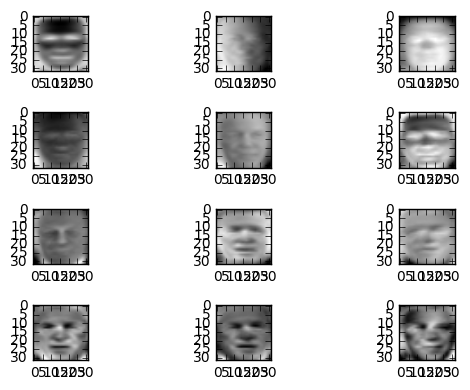

In [132]:
%matplotlib inline
fig = plt.figure()
for i, eigen_face in enumerate(Vt[:12], start=1):
    plt.subplot(4, 3, i)
    plt.tight_layout()
    dim = np.sqrt(np.shape(eigen_face))
    plt.imshow(np.reshape(eigen_face, (dim, dim)), cmap=plt.gray())
plt.show();

## 2d) Gesichtserkennung

Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im Algorithmus)

In [126]:
centralized_test_data = resized_last_images.copy()
centralized_test_data=centralized_test_data-training_data_mean

Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale

In [127]:
test_images = np.dot(Vt[:7], centralized_test_data.T).T
training_images = np.dot(Vt[:7], centralized_training_data.T).T
#maybe eigenvalues instead of Vt
test_images.shape, training_images.shape

((7, 7), (1281, 7))

Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen

In [128]:
#distances{test_name:{training_name:[]}}
distances={}
for test_image, test_name in zip(test_images, resized_last_names):
    dists = {}
    for training_image, training_name in zip(training_images, resized_names):
        dist = sp.spatial.distance.euclidean(test_image, training_image)
        dists.update({training_name:dist})
    distances.update({test_name: dists})
distances

{'Ariel_Sharon': {'Ariel_Sharon': 2.716612567643841,
  'Colin_Powell': 4.0256212025133715,
  'Donald_Rumsfeld': 8.628127547739286,
  'George_W_Bush': 5.381268703857523,
  'Gerhard_Schroeder': 4.749451362917078,
  'Hugo_Chavez': 6.2639992385888075,
  'Tony_Blair': 6.095500550314944},
 'Colin_Powell': {'Ariel_Sharon': 3.205497391290122,
  'Colin_Powell': 3.6388504841372384,
  'Donald_Rumsfeld': 8.985606563109249,
  'George_W_Bush': 4.498093931302551,
  'Gerhard_Schroeder': 4.1903633553558075,
  'Hugo_Chavez': 4.340124291472935,
  'Tony_Blair': 5.871177936289736},
 'Donald_Rumsfeld': {'Ariel_Sharon': 5.365119815237885,
  'Colin_Powell': 5.1017145934703665,
  'Donald_Rumsfeld': 8.4195606516279,
  'George_W_Bush': 3.5773742852442463,
  'Gerhard_Schroeder': 3.1050931999130937,
  'Hugo_Chavez': 5.2050375052170885,
  'Tony_Blair': 7.427978573403165},
 'George_W_Bush': {'Ariel_Sharon': 5.274676946971121,
  'Colin_Powell': 6.620137444567145,
  'Donald_Rumsfeld': 5.69946518716322,
  'George_W_Bus

Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator)
Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

In [129]:
for key, value in distances.items():
    #print(key)
    #print (value)
    b = dict(map(lambda item: (item[1],item[0]),value.items()))
    min_key = b[min(b.keys())]
    print(key," -> ", min_key)


Hugo_Chavez  ->  Hugo_Chavez
George_W_Bush  ->  George_W_Bush
Tony_Blair  ->  George_W_Bush
Colin_Powell  ->  Ariel_Sharon
Gerhard_Schroeder  ->  George_W_Bush
Ariel_Sharon  ->  Ariel_Sharon
Donald_Rumsfeld  ->  Gerhard_Schroeder


# Konfiguration

In [130]:
%load_ext version_information
%version_information numpy, pandas, matplotlib, skimage

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.5.2 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.2.0 27 generic x86_64 with debian jessie sid
numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
skimage 0.12.3
Sat Nov 19 18:12:34 2016 CET